In [1]:
##importing all the dependencies required for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
import pyspark.sql.functions as func
from pyspark.sql import Window

In [2]:
##Configuring spark
spark = SparkSession.builder.appName('Elevator Anamoly').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [3]:
##Reading the input data
input = '/home/keerthi/EDS_12.csv'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()

#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [4]:
##Creating a SQL table

temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,X from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

In [5]:
# UDF for converting column type from vector to double type
unlist = F.udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["X"],
    outputCol="Xvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Xvector", outputCol="Xscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Xscale", unlist("Xscale")).drop("Xvector").cache()
scaledData.show()

+--------------------+---------+---------+
|           timestamp|        X|   Xscale|
+--------------------+---------+---------+
|2018-07-09 12:00:...|-0.023438| 2.083271|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...|-0.023438| 2.083271|
|2018-07-09 12:00:...|-0.035156|-1.628956|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...| -0.03125|-0.391547|
|2018-07-09 12:00:...|-0.027344| 0.845862|
|2018-07-09 12:00:...|-0.035156|-1.628956|
+----------

In [6]:
scaledData.sort(F.desc("Xscale")).show()

+--------------------+--------+---------+
|           timestamp|       X|   Xscale|
+--------------------+--------+---------+
|2018-07-27 14:33:...|0.226563|81.282837|
|2018-07-11 08:17:...|0.175781|65.195252|
|2018-07-25 08:29:...|   0.125|49.107983|
|2018-08-08 08:06:...|0.121094|47.870574|
|2018-08-01 08:35:...|0.121094|47.870574|
|2018-07-25 08:41:...|0.117188|46.633165|
|2018-08-01 08:35:...|0.097656|40.445486|
|2018-07-25 08:30:...|0.097656|40.445486|
|2018-08-08 08:04:...| 0.09375|39.208077|
|2018-07-11 08:14:...| 0.09375|39.208077|
|2018-07-11 08:13:...|0.089844|37.970668|
|2018-08-01 08:49:...|0.089844|37.970668|
|2018-07-11 08:12:...|0.082031|35.495533|
|2018-07-18 08:42:...|0.078125|34.258124|
|2018-08-08 08:07:...|0.078125|34.258124|
|2018-07-25 08:41:...|0.074219|33.020715|
|2018-08-01 08:43:...|0.074219|33.020715|
|2018-07-11 08:16:...|0.070313|31.783306|
|2018-07-11 08:15:...|0.070313|31.783306|
|2018-07-18 08:45:...|0.066406| 30.54558|
+--------------------+--------+---

In [7]:
dummy_df = scaledData.withColumn('Xround', F.round(scaledData['Xscale']))
new_df = dummy_df.groupby('Xround').agg(F.count('Xround').alias('Xcount'))

In [106]:
new_df = new_df.sort(F.desc('Xcount'))
pandas_df = new_df.toPandas()
pandas_df.to_csv('/home/keerthi/count12.csv')
new_df.show()


+------+--------+
|Xround|  Xcount|
+------+--------+
|   0.0|33097330|
|   1.0|22467365|
|  -2.0| 7671748|
|   2.0| 3309490|
|  -3.0|  538275|
|   3.0|  330287|
|  -4.0|   67015|
|   5.0|   55528|
|   6.0|   10889|
|  -5.0|    8916|
|   7.0|    2854|
|  -7.0|    1577|
|   8.0|     917|
|  -8.0|     541|
|  10.0|     320|
|  -9.0|     291|
| -10.0|     183|
| -12.0|     129|
|  11.0|     119|
|  12.0|      88|
+------+--------+
only showing top 20 rows



In [91]:
scaledData.select('*').where(F.round(scaledData['Xscale']) == -4.0).show(100)

+--------------------+---------+---------+
|           timestamp|        X|   Xscale|
+--------------------+---------+---------+
|2018-07-09 12:01:...|-0.042969|-4.104091|
|2018-07-09 12:01:...|-0.042969|-4.104091|
|2018-07-09 12:02:...|-0.042969|-4.104091|
|2018-07-09 12:07:...|-0.042969|-4.104091|
|2018-07-09 12:08:...|-0.042969|-4.104091|
|2018-07-09 12:08:...|-0.042969|-4.104091|
|2018-07-09 12:08:...|-0.042969|-4.104091|
|2018-07-09 12:08:...|-0.042969|-4.104091|
|2018-07-09 12:08:...|-0.042969|-4.104091|
|2018-07-09 12:09:...|-0.042969|-4.104091|
|2018-07-09 12:15:...|-0.042969|-4.104091|
|2018-07-09 12:16:...|-0.042969|-4.104091|
|2018-07-09 12:20:...|-0.042969|-4.104091|
|2018-07-09 12:21:...|-0.042969|-4.104091|
|2018-07-09 12:21:...|-0.042969|-4.104091|
|2018-07-09 12:21:...|-0.042969|-4.104091|
|2018-07-09 12:21:...|-0.042969|-4.104091|
|2018-07-09 12:22:...|-0.042969|-4.104091|
|2018-07-09 12:22:...|-0.042969|-4.104091|
|2018-07-09 12:25:...|-0.042969|-4.104091|
|2018-07-09

In [92]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Xscale from scaledData where timestamp between '2018-07-09 12:08:00' and '2018-07-09 12:09:00'")

In [93]:
temp_df = temp_df.withColumn("timestamp1", F.to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss'))
#temp_df.show()

In [94]:
##Creating a low pass filter
movAvg = temp_df.withColumn("movingAverage", F.avg(temp_df["Xscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-3,3))).cache()
#movAvg.show()

In [13]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [36]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 20.1 ms, sys: 9.13 ms, total: 29.2 ms
Wall time: 10.3 s


In [ ]:
# Plots of Anomalies detected for Lift 11 
#10 different anomalies are plotted here

In [ ]:
##Anamoly 1

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

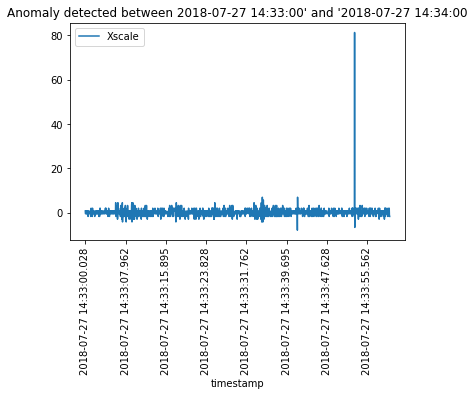

In [37]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-27 14:33:00' and '2018-07-27 14:34:00")
plt.xticks(rotation=90)

In [38]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 66.7 ms, sys: 15 ms, total: 81.8 ms
Wall time: 22.3 s


(array([736902.60625   , 736902.60636574, 736902.60648148, 736902.60659722,
        736902.60671296, 736902.6068287 , 736902.60694444]),
 <a list of 7 Text xticklabel objects>)

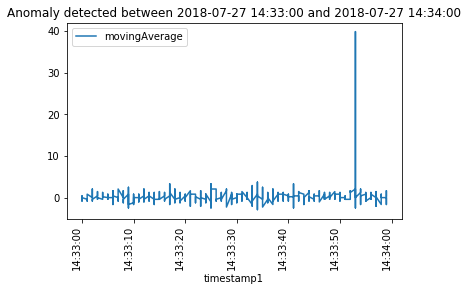

In [39]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-27 14:33:00 and 2018-07-27 14:34:00")
plt.xticks(rotation=90)

In [43]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 21.4 ms, sys: 6.37 ms, total: 27.8 ms
Wall time: 10 s


In [ ]:
##Anamoly 2

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

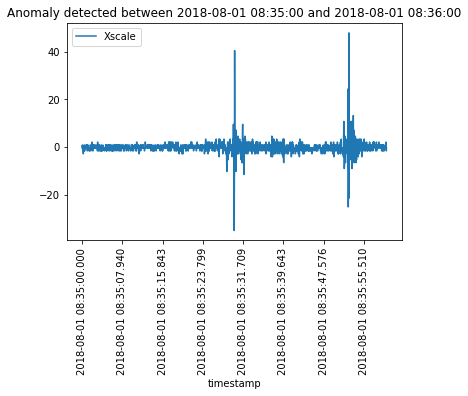

In [44]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-08-01 08:35:00 and 2018-08-01 08:36:00")
plt.xticks(rotation=90)

In [45]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 59.3 ms, sys: 17.3 ms, total: 76.6 ms
Wall time: 20.8 s


(array([736907.35763889, 736907.35775463, 736907.35787037, 736907.35798611,
        736907.35810185, 736907.35821759, 736907.35833333]),
 <a list of 7 Text xticklabel objects>)

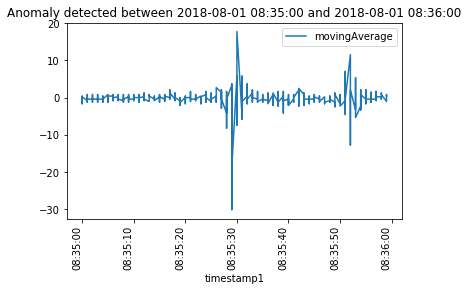

In [46]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-08-01 08:35:00 and 2018-08-01 08:36:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 3

In [50]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 21.8 ms, sys: 4.68 ms, total: 26.4 ms
Wall time: 10 s


In [51]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 72.2 ms, sys: 11.3 ms, total: 83.5 ms
Wall time: 22.5 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

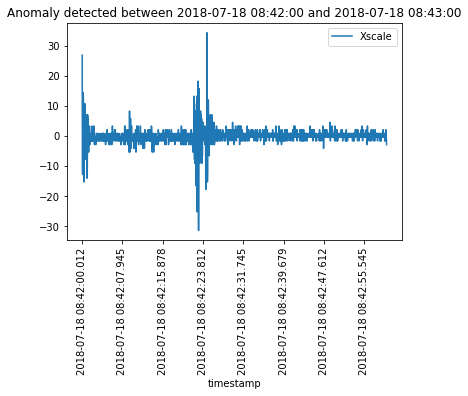

In [52]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-18 08:42:00 and 2018-07-18 08:43:00")
plt.xticks(rotation=90)

(array([736893.3625    , 736893.36261574, 736893.36273148, 736893.36284722,
        736893.36296296, 736893.3630787 , 736893.36319444]),
 <a list of 7 Text xticklabel objects>)

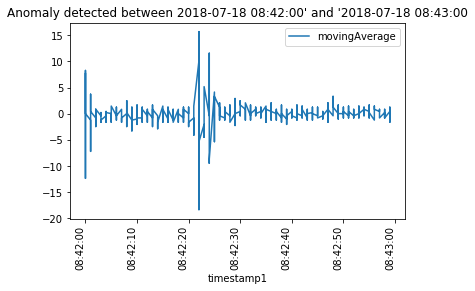

In [53]:
 #This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-18 08:42:00' and '2018-07-18 08:43:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 4

In [57]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 26.2 ms, sys: 11.2 ms, total: 37.3 ms
Wall time: 10.7 s


In [58]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 53 ms, sys: 20.4 ms, total: 73.4 ms
Wall time: 14.9 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

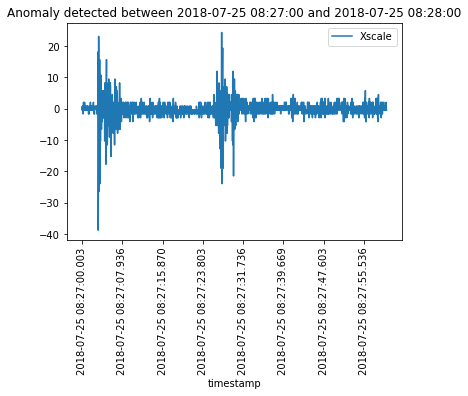

In [59]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-25 08:27:00 and 2018-07-25 08:28:00")
plt.xticks(rotation=90)

(array([736900.35208333, 736900.35219907, 736900.35231481, 736900.35243056,
        736900.3525463 , 736900.35266204, 736900.35277778]),
 <a list of 7 Text xticklabel objects>)

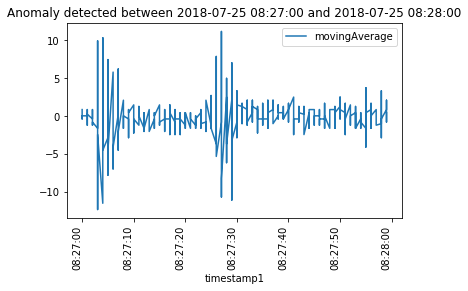

In [60]:
 #This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-25 08:27:00 and 2018-07-25 08:28:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 5

In [73]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 22.6 ms, sys: 6.19 ms, total: 28.8 ms
Wall time: 10.4 s


In [74]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 71.7 ms, sys: 4.95 ms, total: 76.6 ms
Wall time: 17.3 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

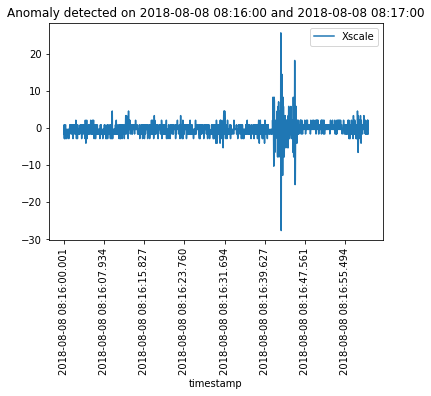

In [75]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-08 08:16:00 and 2018-08-08 08:17:00")
plt.xticks(rotation=90)

(array([736914.34444444, 736914.34456019, 736914.34467593, 736914.34479167,
        736914.34490741, 736914.34502315, 736914.34513889]),
 <a list of 7 Text xticklabel objects>)

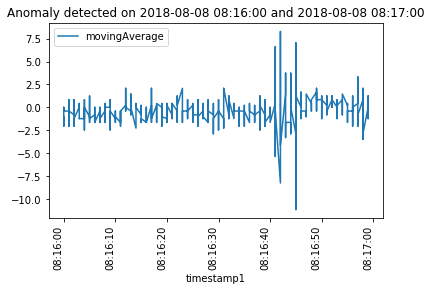

In [76]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-08 08:16:00 and 2018-08-08 08:17:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 6

In [81]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 18 ms, sys: 8.66 ms, total: 26.7 ms
Wall time: 10.4 s


In [82]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 53.7 ms, sys: 9.15 ms, total: 62.9 ms
Wall time: 4.17 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

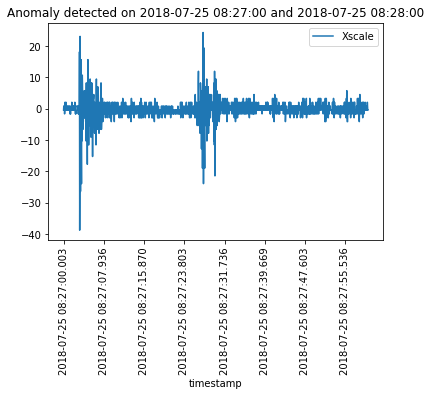

In [83]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-25 08:27:00 and 2018-07-25 08:28:00")
plt.xticks(rotation=90)

(array([736900.35208333, 736900.35219907, 736900.35231481, 736900.35243056,
        736900.3525463 , 736900.35266204, 736900.35277778]),
 <a list of 7 Text xticklabel objects>)

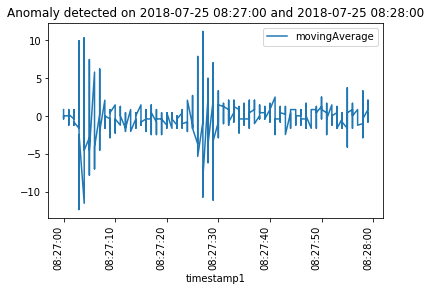

In [84]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-25 08:27:00 and 2018-07-25 08:28:00")
plt.xticks(rotation=90)

In [ ]:
#Anamoly 7

In [89]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 24.4 ms, sys: 4.11 ms, total: 28.6 ms
Wall time: 9.32 s


In [90]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 46.9 ms, sys: 19.2 ms, total: 66.2 ms
Wall time: 16.4 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

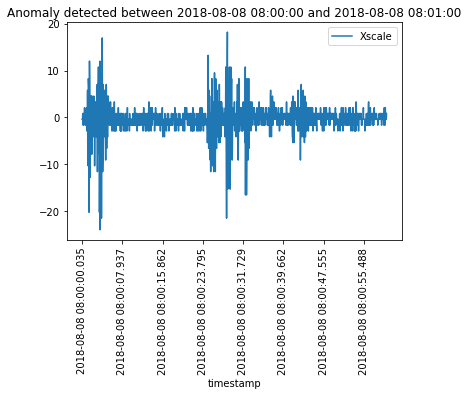

In [91]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-08-08 08:00:00 and 2018-08-08 08:01:00")
plt.xticks(rotation=90)

(array([736914.33333333, 736914.33344907, 736914.33356481, 736914.33368056,
        736914.3337963 , 736914.33391204, 736914.33402778]),
 <a list of 7 Text xticklabel objects>)

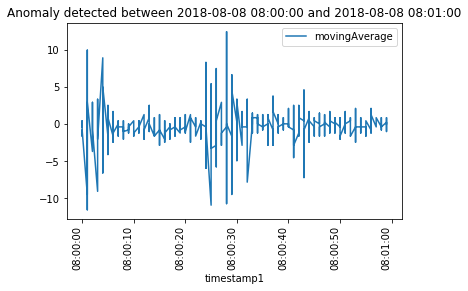

In [92]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-08-08 08:00:00 and 2018-08-08 08:01:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 8

In [108]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 24.2 ms, sys: 4.04 ms, total: 28.3 ms
Wall time: 9.98 s


In [109]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 56.3 ms, sys: 14.2 ms, total: 70.6 ms
Wall time: 14.3 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

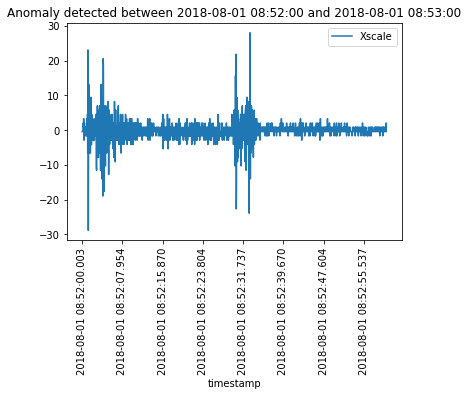

In [110]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-08-01 08:52:00 and 2018-08-01 08:53:00")
plt.xticks(rotation=90)

(array([736907.36944444, 736907.36956019, 736907.36967593, 736907.36979167,
        736907.36990741, 736907.37002315, 736907.37013889]),
 <a list of 7 Text xticklabel objects>)

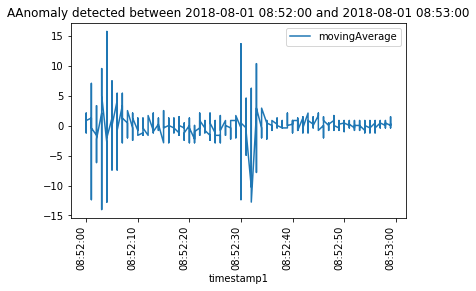

In [111]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("AAnomaly detected between 2018-08-01 08:52:00 and 2018-08-01 08:53:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 9

In [115]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 22 ms, sys: 8.54 ms, total: 30.6 ms
Wall time: 10.6 s


In [116]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 38 ms, sys: 31.7 ms, total: 69.7 ms
Wall time: 12.6 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

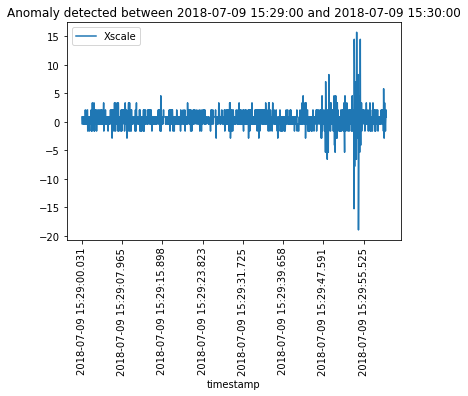

In [117]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-09 15:29:00 and 2018-07-09 15:30:00")
plt.xticks(rotation=90)

(array([736884.64513889, 736884.64525463, 736884.64537037, 736884.64548611,
        736884.64560185, 736884.64571759, 736884.64583333]),
 <a list of 7 Text xticklabel objects>)

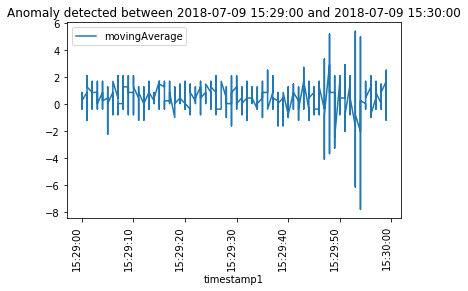

In [118]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-09 15:29:00 and 2018-07-09 15:30:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 10

In [65]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 3.96 s


In [129]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 43.4 ms, sys: 24.6 ms, total: 67.9 ms
Wall time: 11.6 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

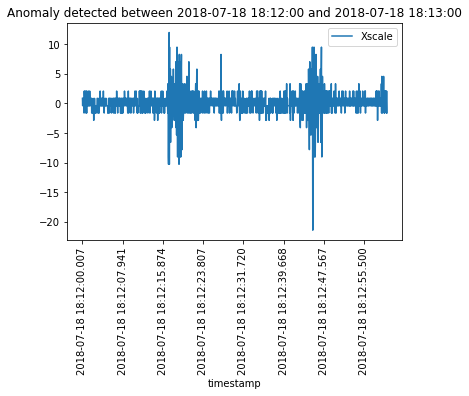

In [131]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-18 18:12:00 and 2018-07-18 18:13:00")
plt.xticks(rotation=90)

(array([736893.75833333, 736893.75844907, 736893.75856481, 736893.75868056,
        736893.7587963 , 736893.75891204, 736893.75902778]),
 <a list of 7 Text xticklabel objects>)

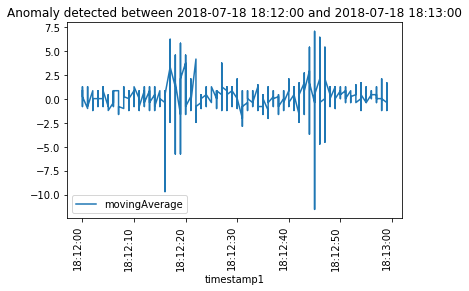

In [132]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-18 18:12:00 and 2018-07-18 18:13:00")
plt.xticks(rotation=90)

In [ ]:
###Normal Cases

In [ ]:
##Normal Case 1

In [87]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 10.5 s


In [88]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 64.4 ms, sys: 9.66 ms, total: 74 ms
Wall time: 18.8 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

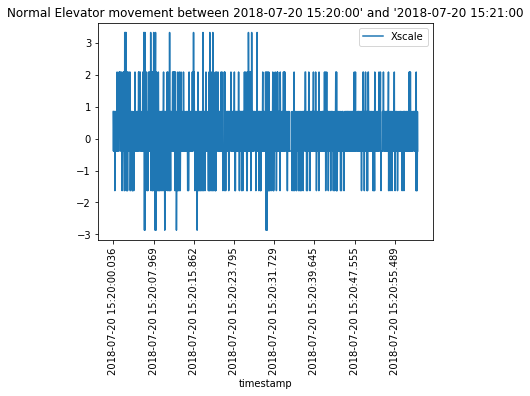

In [89]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line') 
plt.title("Normal Elevator movement between 2018-07-20 15:20:00' and '2018-07-20 15:21:00")
plt.xticks(rotation=90)

(array([736895.63888889, 736895.63900463, 736895.63912037, 736895.63923611,
        736895.63935185, 736895.63946759, 736895.63958333]),
 <a list of 7 Text xticklabel objects>)

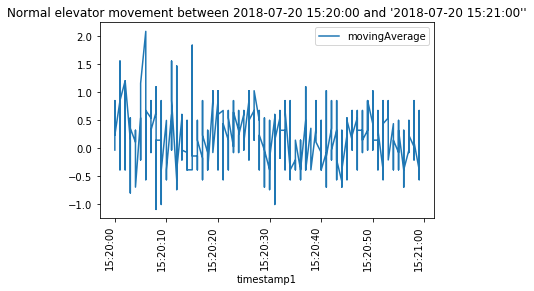

In [90]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Normal elevator movement between 2018-07-20 15:20:00 and '2018-07-20 15:21:00''")
plt.xticks(rotation=90)

In [ ]:
##Normal 2

In [76]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 32.6 ms, sys: 10.5 ms, total: 43.1 ms
Wall time: 16.6 s


In [77]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 69.7 ms, sys: 13.4 ms, total: 83.1 ms
Wall time: 18 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

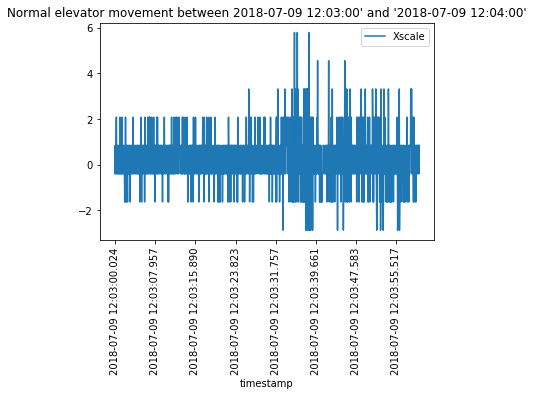

In [83]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Normal elevator movement between 2018-07-09 12:03:00' and '2018-07-09 12:04:00'")
plt.xticks(rotation=90)

(array([736884.50208333, 736884.50219907, 736884.50231481, 736884.50243056,
        736884.5025463 , 736884.50266204, 736884.50277778]),
 <a list of 7 Text xticklabel objects>)

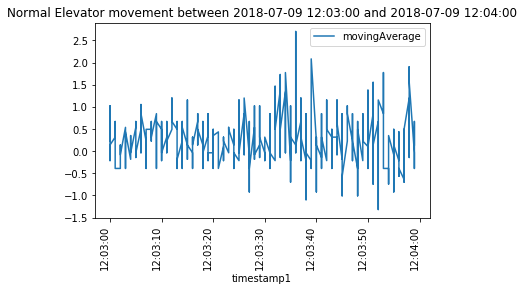

In [82]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title('Normal Elevator movement between 2018-07-09 12:03:00 and 2018-07-09 12:04:00')
plt.xticks(rotation=90)

In [ ]:
##Normal Case 3

In [100]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 23.1 ms, sys: 5.05 ms, total: 28.2 ms
Wall time: 11.3 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

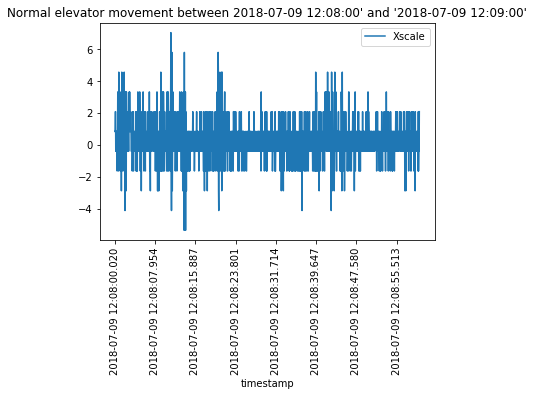

In [102]:
temp_pandas.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Normal elevator movement between 2018-07-09 12:08:00' and '2018-07-09 12:09:00'")
plt.xticks(rotation=90)

In [104]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 63.4 ms, sys: 3.84 ms, total: 67.2 ms
Wall time: 3.54 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

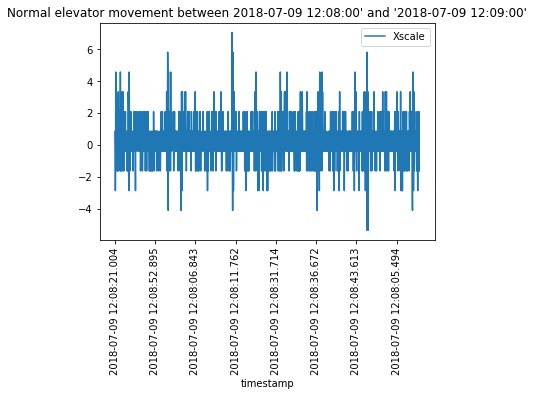

In [105]:
temp_avg.plot(x ='timestamp', y='Xscale', kind = 'line')
plt.title("Normal elevator movement between 2018-07-09 12:08:00' and '2018-07-09 12:09:00'")
plt.xticks(rotation=90)